# RNA-ATAC: unpaired data training

The following tutorial demonstrate how to use unpaired data to train a scButterfly model.

Get inspiration from [scButterfly-T](../RNA_ATAC_paired_prediction/RNA_ATAC_paired_scButterfly-T.ipynb), we could randomly pair RNA profile and ATAC profile of different cell with the same cell types.

There are three part of this tutorial:

* **Load data and data pre-processing**. This part will tell you how to load and pre-process scRNA-seq and scATAC-seq data for scButterfly model. 

* **Construct and train a scButterfly model**. This part will tell you how to generate and train a scButterfly model correctly.

* **Get prediction and evaluate the performance**. This part will tell you how to get prediction from scButterfly model and evaluate the performance of prediction.

<div class="alert note">
<p>

**Note**

This tutorial shows the powerful ability of versatile scButterfly framework. You could follow this tutorial to make diagnal analysis with scButterfly.

</p>
</div>

In [1]:
import scanpy as sc
import pandas as pd

## Load data and data pre-processing

Here we use the adult human kidney dataset as example. ([Muto Y, et al., 2021](https://www.nature.com/articles/s41467-021-22368-w))

In [2]:
ATAC_data = sc.read_h5ad('Muto_ATAC_data.h5ad')
RNA_data = sc.read_h5ad('Muto_RNA_data.h5ad')
RNA_data.obs.index = pd.Series([str(i) for i in range(len(RNA_data.obs.index))])
ATAC_data.obs.index = pd.Series([str(i) for i in range(len(ATAC_data.obs.index))])

In [3]:
RNA_data

AnnData object with n_obs × n_vars = 19985 × 27146
    obs: 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'donor_uuid', 'ethnicity_ontology_term_id', 'library_uuid', 'mapped_reference_annotation', 'organism_ontology_term_id', 'sample_preservation_method', 'sample_uuid', 'suspension_type', 'suspension_uuid', 'tissue_ontology_term_id', 'is_primary_data', 'author_cell_type', 'cell_type_category', 'cell_type_ontology_term_id', 'author_cluster', 'disease_ontology_term_id', 'reported_diseases', 'sex_ontology_term_id', 'percent.mt', 'percent.rpl', 'percent.rps', 'nCount_SCT', 'nFeature_SCT', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'ethnicity', 'development_stage', 'domain', 'protocol', 'dataset', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'tag', 'n_c

In [4]:
ATAC_data

AnnData object with n_obs × n_vars = 24205 × 99019
    obs: 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'donor_uuid', 'ethnicity_ontology_term_id', 'library_uuid', 'organism_ontology_term_id', 'sample_preservation_method', 'sample_uuid', 'suspension_type', 'suspension_uuid', 'tissue_ontology_term_id', 'is_primary_data', 'author_cell_type', 'cell_type_category', 'cell_type_ontology_term_id', 'author_cluster', 'disease_ontology_term_id', 'reported_diseases', 'sex_ontology_term_id', 'nCount_RNA', 'nFeature_RNA', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'ethnicity', 'development_stage', 'domain', 'protocol', 'dataset', 'batch'
    var: 'chrom', 'chromStart', 'chromEnd', 'genome', 'n_counts'
    uns: 'X_normalization', 'default_embedding', 'layer_descriptions', 'schema_version', 'title'
    obsm: 'X_umap'

First, we pre-process data using ``RNA_data_preprocessing`` and ``ATAC_data_preprocessing`` in ``scButterfly.data_processing``.

In [5]:
from scButterfly.data_processing import RNA_data_preprocessing, ATAC_data_preprocessing

In [6]:
RNA_data = RNA_data_preprocessing(
    RNA_data,
    normalize_total=True,
    log1p=True,
    use_hvg=True,
    n_top_genes=3000,
    save_data=False,
    file_path=None,
    logging_path=None
    )
ATAC_data = ATAC_data_preprocessing(
    ATAC_data,
    binary_data=True,
    filter_features=True,
    fpeaks=0.005,
    tfidf=True,
    normalize=True,
    save_data=False,
    file_path=None,
    logging_path=None
)[0]

[INFO] RNA preprocessing: normalize size factor.
[INFO] RNA preprocessing: log transform RNA data.
[INFO] RNA preprocessing: choose top 3000 genes for following training.
[INFO] ATAC preprocessing: binarizing data.
[INFO] ATAC preprocessing: filter out peaks appear lower than 0.5% cells.
[INFO] ATAC preprocessing: TF-IDF transformation.
[INFO] ATAC preprocessing: normalizing data.


Here we sample some synthetic paired RNA and ATAC of different cells in the same cell types. You could use ``unpaired_split_dataset`` in ``scButterfly.split_datasets`` to reproduce the process of sampling same with scButterfly manuscript.

In [7]:
from scButterfly.split_datasets import *
id_list = unpaired_split_dataset_muto(RNA_data, ATAC_data)
train_id_r, train_id_a, validation_id_r, validation_id_a, test_id_r, test_id_a = id_list[0]

## Construct and train a scButterfly model

Calculate the counts of peaks in each chromosomes.

In [8]:
ATAC_data.var.chrom

peaks
chr1:826622-827992          chr1
chr1:835447-835975          chr1
chr1:869609-870367          chr1
chr1:876650-877672          chr1
chr1:903810-907253          chr1
                            ... 
chrX:155264099-155264764    chrX
chrX:155612050-155613299    chrX
chrX:155767079-155768180    chrX
chrX:155820008-155820575    chrX
chrX:155880588-155881957    chrX
Name: chrom, Length: 98780, dtype: category
Categories (23, object): ['chr1', 'chr2', 'chr3', 'chr4', ..., 'chr20', 'chr21', 'chr22', 'chrX']

In [9]:
chrom_list = []
last_one = ''
for i in range(len(ATAC_data.var.chrom)):
    temp = ATAC_data.var.chrom[i]
    if temp[0 : 3] == 'chr':
        if not temp == last_one:
            chrom_list.append(1)
            last_one = temp
        else:
            chrom_list[-1] += 1
    else:
        chrom_list[-1] += 1
        
print(chrom_list, end="")

[9239, 4854, 5125, 4783, 2765, 3240, 3198, 3357, 4105, 2316, 2999, 7909, 2492, 1082, 1955, 6678, 5157, 5448, 5938, 4946, 4392, 4461, 2341]

In [10]:
sum(chrom_list)

98780

We could load scButterfly model for scRNA-seq and scATAC-seq from ``scButterfly.train_model``

<div class="alert warning">
<p>

**Warning**

We propose you to ensure that the settings of parameters for pre-processing, construct model and train model are same with here, while feel free to decide path for logging and model output.

</p>
</div>

In [11]:
from scButterfly.train_model import Model
import torch
import torch.nn as nn

In [12]:
RNA_input_dim = len([i for i in RNA_data.var['highly_variable'] if i])
ATAC_input_dim = ATAC_data.X.shape[1]

R_kl_div = 1 / RNA_input_dim * 20
A_kl_div = 1 / ATAC_input_dim * 20
kl_div = R_kl_div + A_kl_div

In [13]:
model = Model(
    R_encoder_nlayer = 2, 
    A_encoder_nlayer = 2,
    R_decoder_nlayer = 2, 
    A_decoder_nlayer = 2,
    R_encoder_dim_list = [RNA_input_dim, 256, 128],
    A_encoder_dim_list = [ATAC_input_dim, 32 * len(chrom_list), 128],
    R_decoder_dim_list = [128, 256, RNA_input_dim],
    A_decoder_dim_list = [128, 32 * len(chrom_list), ATAC_input_dim],
    R_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    R_decoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_decoder_act_list = [nn.LeakyReLU(), nn.Sigmoid()],
    translator_embed_dim = 128, 
    translator_input_dim_r = 128,
    translator_input_dim_a = 128,
    translator_embed_act_list = [nn.LeakyReLU(), nn.LeakyReLU(), nn.LeakyReLU()],
    discriminator_nlayer = 1,
    discriminator_dim_list_R = [128],
    discriminator_dim_list_A = [128],
    discriminator_act_list = [nn.Sigmoid()],
    dropout_rate = 0.1,
    R_noise_rate = 0.5,
    A_noise_rate = 0.3,
    chrom_list = chrom_list,
    logging_path = None,
    RNA_data = RNA_data,
    ATAC_data = ATAC_data
)

Train a scButterfly-T model.

In [14]:
model.train(
    R_encoder_lr = 0.001,
    A_encoder_lr = 0.001,
    R_decoder_lr = 0.001,
    A_decoder_lr = 0.001,
    R_translator_lr = 0.001,
    A_translator_lr = 0.001,
    translator_lr = 0.001,
    discriminator_lr = 0.005,
    R2R_pretrain_epoch = 100,
    A2A_pretrain_epoch = 100,
    lock_encoder_and_decoder = False,
    translator_epoch = 200,
    patience = 50,
    batch_size = 64,
    r_loss = nn.MSELoss(size_average=True),
    a_loss = nn.BCELoss(size_average=True),
    d_loss = nn.BCELoss(size_average=True),
    loss_weight = [1, 2, 1, R_kl_div, A_kl_div, kl_div],
    train_id_r = train_id_r,
    train_id_a = train_id_a,
    validation_id_r = validation_id_r, 
    validation_id_a = validation_id_a, 
    output_path = None,
    seed = 19193,
    kl_mean = True,
    R_pretrain_kl_warmup = 50,
    A_pretrain_kl_warmup = 50,
    translation_kl_warmup = 50,
    load_model = None,
    logging_path = None
)

[INFO] Trainer: RNA pretraining ...
RNA pretrain: 100%|█████████████████████| 100/100 [23:35<00:00, 14.15s/it, train=0.0496, val=0.0319]
[INFO] Trainer: ATAC pretraining ...
ATAC pretrain: 100%|████████████████████| 100/100 [25:04<00:00, 15.04s/it, train=0.0393, val=0.0382]
[INFO] Trainer: Combine training ...
Combine training:  33%|█████▉            | 66/200 [23:17<47:17, 21.18s/it, train=0.2605, val=0.2188]


## Get prediction and evaluate the performance

You could get cross-modal predictions using ``model.test`` using ``return_predict=True``. We also provided more information metrics in this function, see in [API](../../API/index.html).

In [15]:
A2R_predict, R2A_predict = model.test(
    test_id_r = test_id_r,
    test_id_a = test_id_a, 
    model_path = None,
    load_model = False,
    output_path = None,
    test_cluster = False,
    test_figure = False,
    output_data = False,
    return_predict = True
)

[INFO] Tester: get predicting ...
ATAC to RNA predicting...: 100%|██████████████████████████████████| 105/105 [00:06<00:00, 15.42it/s]
[INFO] Tester: calculate neighbors graph for following test ...


Here we draw the [t-SNE](https://jmlr.org/papers/v9/vandermaaten08a.html) embeddings and measure the ARI, AMI, NMI, and HOM.

In [16]:
from scButterfly.calculate_cluster import calculate_cluster_index

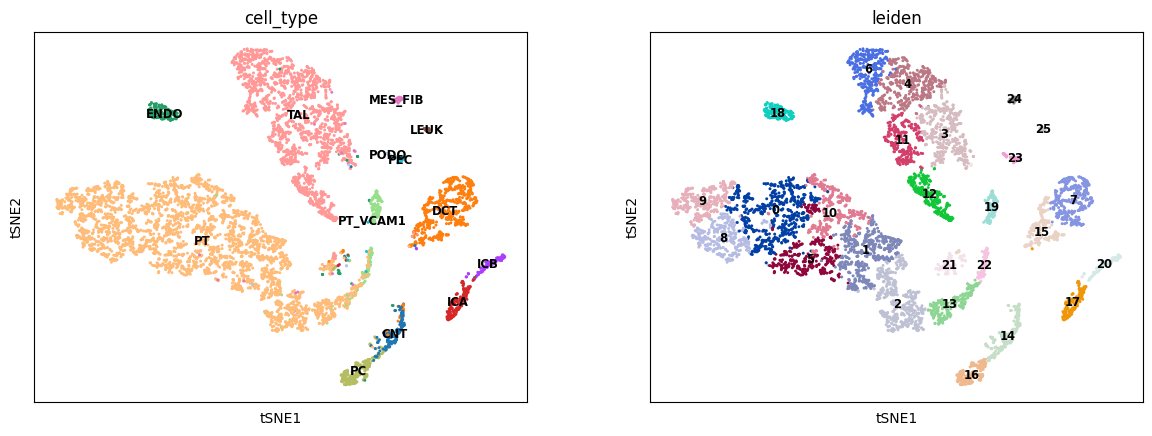

In [17]:
sc.tl.tsne(A2R_predict)
sc.tl.leiden(A2R_predict)
sc.pl.tsne(A2R_predict, color=['cell_type', 'leiden'], legend_loc='on data', legend_fontsize='small')

In [18]:
ARI, AMI, NMI, HOM = calculate_cluster_index(A2R_predict)
print('ATAC to RNA:\nARI: %.3f, \tAMI: %.3f, \tNMI: %.3f, \tHOM: %.3f' % (ARI, AMI, NMI, HOM))

ATAC to RNA:
ARI: 0.208, 	AMI: 0.621, 	NMI: 0.625, 	HOM: 0.916, 	COM: 0.474


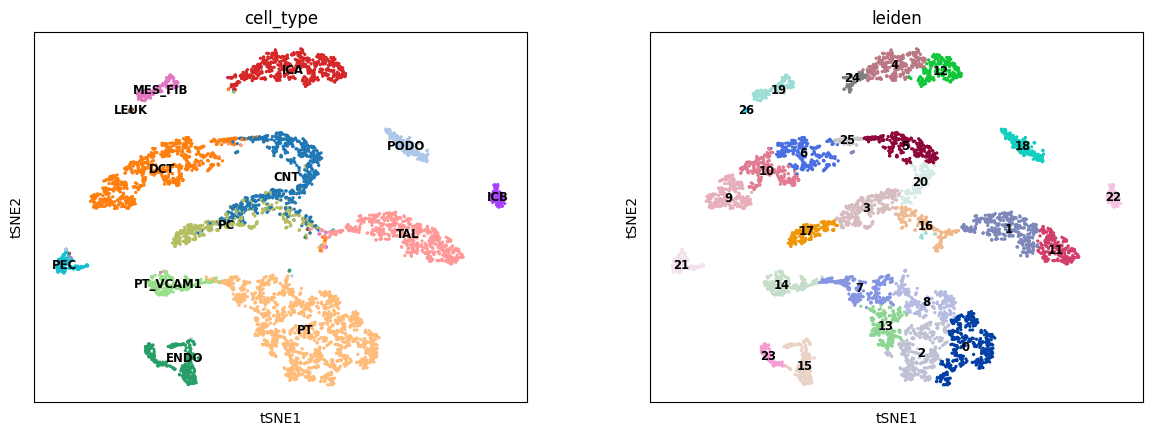

In [19]:
sc.tl.tsne(R2A_predict)
sc.tl.leiden(R2A_predict)
sc.pl.tsne(R2A_predict, color=['cell_type', 'leiden'], legend_loc='on data', legend_fontsize='small')

In [20]:
ARI, AMI, NMI, HOM = calculate_cluster_index(R2A_predict)
print('RNA to ATAC:\nARI: %.3f, \tAMI: %.3f, \tNMI: %.3f, \tHOM: %.3f' % (ARI, AMI, NMI, HOM))

RNA to ATAC:
ARI: 0.411, 	AMI: 0.755, 	NMI: 0.758, 	HOM: 0.925, 	COM: 0.642
